In [1]:
from utils import *
import sqlite3
import numpy as np
import pandas as pd
from slither import Slither
from sqlalchemy import create_engine
connection = sqlite3.connect('contracts_found.db')

engine = create_engine('sqlite:///contracts_found.db')
contracts_found = pd.read_sql_query("SELECT * FROM contracts_found", connection)


verified_contracts =  pd.read_sql_query("SELECT * FROM contracts_found_enriched", connection)

try:
    contracts_found =pd.concat([contracts_found[~contracts_found.Contract.isin(verified_contracts.Contract)], verified_contracts])
    contracts_found["error"] = contracts_found.error.astype(str)
    contracts_found.drop_duplicates(subset='Contract', inplace=True)
    contracts_found.reset_index(drop=True, inplace=True)
except:
    contracts_found.drop_duplicates(subset='Contract', inplace=True)
    contracts_found.reset_index(drop=True, inplace=True)
    contracts_found['error'] = np.nan
    contracts_found['success'] = np.nan
    
print(len(contracts_found))


1959


In [2]:
sl_objects = dict()

In [3]:
for i in range(len(contracts_found)):
    if contracts_found.loc[i, 'success'] ==1:
        continue
    if 'Unknown language: unknown' in str(contracts_found.loc[i, 'error']) or 'Symbol not found:' in str(contracts_found.loc[i, 'error']):
        continue
        
    import time
    
    try:
                
        contract_address = contracts_found['Contract'][i]
        print(contract_address)
        sl = Slither(contract_address, etherscan_api_key = 'J54BEV9S8I4B26KU9BV98G6H3ASJRJ7IG7')
        contracts_found.loc[i, 'success'] = 1
        sl_objects[contract_address] = sl
        time.sleep(2)
        print(1)
    except Exception as e:
        print(e)
        contracts_found.loc[i, 'success'] = 0
        contracts_found.loc[i, 'error'] = e
        time.sleep(2)


0x5315488eF66eCa23e31238cf64b968eAa190Ec96
Invalid compilation: 
Invalid solc compilation 
0xdD46Db29406a71B8000F613cB62ad04d579b1854
Invalid compilation: 
Invalid solc compilation dyld: Symbol not found: __ZNKSt3__115basic_stringbufIcNS_11char_traitsIcEENS_9allocatorIcEEE3strEv
  Referenced from: /Users/enrique/.solc-select/artifacts/solc-0.8.24/solc-0.8.24 (which was built for Mac OS X 13.5)
  Expected in: /usr/lib/libc++.1.dylib


0x39c973162F2af3dd7Dc8BfBEcc7fdC0b8602B979
Invalid compilation: 
Invalid solc compilation 
0xB943Bd7DA6948324363025E3fE789CD02c846C86
Invalid compilation: 
Invalid solc compilation 
0xd6Bf13548d404c72c182FF773371A23Bc432fF02
1
0xfC2EBc9432Bdc1DFF8b853bC8215898D48b3B1B5
1
0xd5a64e5C53Aff2eDb81fF20B2984b9173F331d3B
1
0x524796F1290Ab99034C347d3193c8A2e748E6DDF
Invalid compilation: 
Invalid solc compilation dyld: Symbol not found: __ZNKSt3__115basic_stringbufIcNS_11char_traitsIcEENS_9allocatorIcEEE3strEv
  Referenced from: /Users/enrique/.solc-select/artifacts

In [256]:
verified_contracts = contracts_found[contracts_found['success'] ==1].reset_index(drop=True)
verified_contracts

,Unnamed: 0,index,Name,Ticker,Contract,error,success
0,1.0,1.0,Pepewifhat,PWIF,0x216463D71EAA305872fB97FBd40559CaEce39749,NaN,1.0
1,8.0,10.0,PepeTrump,PepeTrump,0xa5f6182455A381ddcfc2eaF3984EfeEB95017627,NaN,1.0
2,9.0,11.0,KANSHA,KSH,0x625933f04eb04f33Ac489c952854165C7cc4A2fd,NaN,1.0
3,10.0,12.0,Miltzn Home,MH,0xb8D44feCbAC44eA6Ea25D5480e0a902548870ed1,NaN,1.0
4,19.0,21.0,KUMATAMA Only One Collection,koc,0x1EB3Add1D2B0B047766b6978303Be52F60bec2f9,NaN,1.0
...,...,...,...,...,...,...,...
117,NaN,NaN,Blendr Network,BLENDR,0x84018071282d4B2996272659D9C01cB08DD7327F,NaN,1.0
118,NaN,NaN,Krick Coin,KRICK,0x4F0E058C5e8895d576390eA0b8E351F063b34f81,NaN,1.0
119,NaN,NaN,Founder,FNDR,0x155aB13F7c552C5a0856A4b67637D4b0bB456330,NaN,1.0
120,NaN,NaN,PepeTimes,PEPETIMES,0x481d9D3fF5E891d97f9070345470F8dD91D7f3F3,NaN,1.0


In [259]:
contracts_found[(contracts_found.error.astype(str) !='Unknown language: unknown')&(contracts_found.error.astype(str) !='Symbol')].success.value_counts()

success
0.0    232
1.0    122
Name: count, dtype: int64

In [33]:
compilation_unit = sl.compilation_units[0]
# Print all the contracts from the USDT address
print([str(c) for c in compilation_unit.contracts])
# Print the most derived contracts from the USDT address
print([str(c) for c in compilation_unit.contracts_derived])

['IERC20', 'Context', 'Ownable', 'SafeMath', 'BaseToken', 'StandardToken']
['SafeMath', 'StandardToken']


In [266]:
import numpy as np
# verified_contracts['max_price_in_eth'] =np.nan
for i in range(len(verified_contracts)):
    if pd.notnull(verified_contracts.loc[i, 'max_price_in_eth']):
        continue

    token_contract_address_token = verified_contracts['Contract'].values[i]

    response = get_monthly_prices_for_a_token(token_contract_address_token)
    
    try:
        if len(response.json()['data']['ethereum']['dexTrades']) == 0:
            max_price_in_eth = 0
        else:
            max_price_in_eth = response.json()['data']['ethereum']['dexTrades'][0]['maximum_price']

    except:
        print('error getting prices for', token_contract_address_token)
        max_price_in_eth = 0

    try:
        token_supply = get_supply(token_contract_address_token)
    except:
        token_supply = 0

    max_market_cap_in_eth = token_supply*max_price_in_eth
    
    verified_contracts.loc[i, 'max_price_in_eth'] = max_price_in_eth
    verified_contracts.loc[i, 'token_supply'] = token_supply
    verified_contracts.loc[i, 'max_market_cap_in_eth'] = max_market_cap_in_eth
    
    print(token_contract_address_token, max_price_in_eth, token_supply, max_market_cap_in_eth)
    
verified_contracts['max_market_cap_in_eth'] = verified_contracts.max_market_cap_in_eth.astype(int)

{'data': {'ethereum': {'dexTrades': []}}}
Total Supply: 1000000000.0
0x216463D71EAA305872fB97FBd40559CaEce39749 0 1000000000.0 0.0
{'data': {'ethereum': {'dexTrades': [{'timeInterval': {'month': '2024-03-01'}, 'buyCurrency': {'symbol': 'PepeTrump', 'address': '0xa5f6182455a381ddcfc2eaf3984efeeb95017627'}, 'buyAmount': 854239873926.3235, 'sellCurrency': {'symbol': 'WETH', 'address': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'}, 'sellAmount': 4.798477786990575, 'trades': 101, 'maximum_price': 1.2223440476219541e-11, 'minimum_price': 1.7366297818969466e-12, 'open_price': '1.1151459093540261e-11', 'close_price': '1.7718921622970446e-12'}]}}}
Total Supply: 1000000000000.0
0xa5f6182455A381ddcfc2eaF3984EfeEB95017627 1.2223440476219541e-11 1000000000000.0 12.22344047621954
{'data': {'ethereum': {'dexTrades': [{'timeInterval': {'month': '2024-03-01'}, 'buyCurrency': {'symbol': 'KSH', 'address': '0x625933f04eb04f33ac489c952854165c7cc4a2fd'}, 'buyAmount': 151751794.0579154, 'sellCurrency': {'sym

In [ ]:
def get_number_contracts(contract_address):
    compilation_unit = sl_objects[contract_address].compilation_units[0]
    return len(pd.Series([str(c) for c in compilation_unit.contracts]))

verified_contracts["number_contracts"] = verified_contracts.Contract.apply(get_number_contracts)
traded_verified_contracts = verified_contracts[verified_contracts.max_market_cap_in_eth>0]
traded_verified_contracts.reset_index(drop=True,inplace=True)

In [343]:
traded_verified_contracts[traded_verified_contracts.max_market_cap_in_eth >0][["max_market_cap_in_eth", "number_contracts"]].corr()

,max_market_cap_in_eth,get_number_funtions
max_market_cap_in_eth,1.00000,0.46034
get_number_funtions,0.46034,1.00000


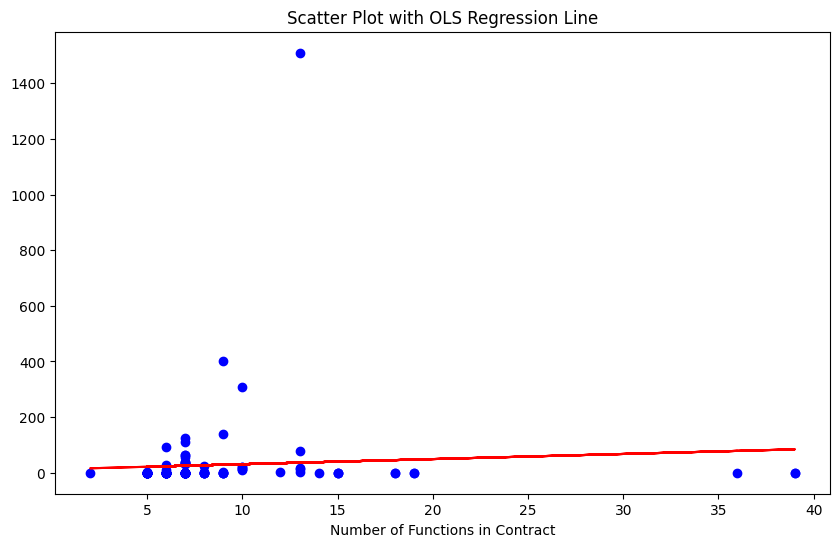

In [339]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Simulating data for demonstration
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(verified_contracts[verified_contracts.max_market_cap_in_eth <53485]['get_number_funtions'], verified_contracts[verified_contracts.max_market_cap_in_eth <53485]['max_market_cap_in_eth'], color='blue', label='Data Points')

# Linear Regression using OLS
X = sm.add_constant(verified_contracts[verified_contracts.max_market_cap_in_eth <53485]['get_number_funtions'])  # adding a constant
model = sm.OLS(verified_contracts[verified_contracts.max_market_cap_in_eth <53485]['max_market_cap_in_eth'], X).fit()
predictions = model.predict(X)

# Adding the regression line to the plot
plt.plot(verified_contracts[verified_contracts.max_market_cap_in_eth <53485]['get_number_funtions'], predictions, color='red', label='OLS Regression Line')
plt.title('Scatter Plot with OLS Regression Line')
plt.xlabel('Number of Functions in Contract')
plt.show()


In [361]:
# Initialize SQL database connection using SQLAlchemy
engine = create_engine('sqlite:///contracts_found.db')

contracts_found_enriched =pd.concat([contracts_found[~contracts_found.Contract.isin(verified_contracts.Contract)], verified_contracts])
contracts_found_enriched["error"] = contracts_found_enriched.error.astype(str)
contracts_found_enriched.to_sql('contracts_found_enriched', con=engine, index=False, if_exists='append')


431

In [ ]:
corpus_state_variables = []
corpus_contract_names = []
index_contract_names = []
index_state_variables = []
traded_verified_contracts['count_vars'] = 0
for i in range(len(traded_verified_contracts)):
    
    contract_address = traded_verified_contracts.sort_values(by = 'max_market_cap_in_eth', ascending=False)['Contract'].values[i]
    compilation_unit = sl_objects[contract_address].compilation_units[0]    
    
    corpus_contract_names.append(" ".join([str(c) for c in compilation_unit.contracts]))
    index_contract_names.append(i)
    
    for j in range(len([str(c) for c in compilation_unit.contracts])):
        
        contract = compilation_unit.get_contract_from_name([str(c) for c in compilation_unit.contracts][j])[0]
        
        corpus_state_variables.append(" ".join([str(v) for v in contract.state_variables]))
        index_state_variables.append(i)
        traded_verified_contracts.loc[i, 'count_vars'] +=1
        
        
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer()

# Fit and transform the corpus
tfidf_matrix = vectorizer.fit_transform(corpus_contract_names)

# Get feature names to use as dataframe column headers
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame with the TF-IDF scores
import pandas as pd
df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
df

tfidf_score_per_token_contract_names = pd.concat([df, pd.Series(index_contract_names, name='index_')], axis=1).groupby('index_').sum().sum(axis=1)

traded_verified_contracts = pd.concat([traded_verified_contracts, pd.Series(tfidf_score_per_token_contract_names, name='tfidf_score_per_token_contract_names')], axis=1)

In [ ]:

vectorizer = TfidfVectorizer()

# Fit and transform the corpus
tfidf_matrix = vectorizer.fit_transform(corpus_state_variables)

# Get feature names to use as dataframe column headers
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame with the TF-IDF scores
import pandas as pd
df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
df

tfidf_score_per_token_state_variables = pd.concat([df, pd.Series(index_state_variables, name='index_')], axis=1).groupby('index_').sum().sum(axis=1)

traded_verified_contracts = pd.concat([traded_verified_contracts, pd.Series(tfidf_score_per_token_state_variables, name='tfidf_score_per_token_state_variables')], axis=1)

In [498]:
# correlation between max marketcap and the number of state variables across all contracts of a token
traded_verified_contracts[['max_market_cap_in_eth', 'count_vars']].corr()


,max_market_cap_in_eth,count_vars
max_market_cap_in_eth,1.000000,0.261857
count_vars,0.261857,1.000000


In [501]:
# correlation between max marketcap and the uniqueness of the contract names and state variables of a token
traded_verified_contracts[['max_market_cap_in_eth', 'tfidf_score_per_token']].corr()

,max_market_cap_in_eth,tfidf_score_per_token
max_market_cap_in_eth,1.000000,0.066512
tfidf_score_per_token,0.066512,1.000000


In [ ]:
traded_verified_contracts[['max_market_cap_in_eth', 
                           'tfidf_score_per_token_state_variables', 
                           'tfidf_score_per_token_contract_names', 
                           'count_vars', 
                           'number_contracts']]